In [1]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import zipfile
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [2]:

# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix='D:/가천대학교 3-2/딥러닝/human+activity+recognition+using+smartphones/UCI HAR Dataset/'):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix='D:/가천대학교 3-2/딥러닝/human+activity+recognition+using+smartphones/UCI HAR Dataset/'):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix='D:/가천대학교 3-2/딥러닝/human+activity+recognition+using+smartphones/'):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [3]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [4]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))
model.add(LSTM(100, return_sequences=False))  # return_sequences를 False로 변경
model.add(Dropout(0.5))
model.add(Dense(n_outputs, activation='softmax'))

In [5]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
# 모델 훈련
batch_size = 64
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True, validation_split=0.2)

Epoch 1/10
92/92 [==============================] - 17s 156ms/step - loss: 1.0146 - accuracy: 0.5553 - val_loss: 0.6849 - val_accuracy: 0.7505
Epoch 2/10
92/92 [==============================] - 14s 147ms/step - loss: 0.6089 - accuracy: 0.7320 - val_loss: 0.6833 - val_accuracy: 0.7274
Epoch 3/10
92/92 [==============================] - 14s 147ms/step - loss: 0.4610 - accuracy: 0.8152 - val_loss: 0.5236 - val_accuracy: 0.8368
Epoch 4/10
92/92 [==============================] - 14s 155ms/step - loss: 0.3879 - accuracy: 0.8543 - val_loss: 0.4898 - val_accuracy: 0.8436
Epoch 5/10
92/92 [==============================] - 14s 154ms/step - loss: 0.3790 - accuracy: 0.8740 - val_loss: 0.4866 - val_accuracy: 0.8797
Epoch 6/10
92/92 [==============================] - 14s 156ms/step - loss: 0.3111 - accuracy: 0.8956 - val_loss: 0.4002 - val_accuracy: 0.8919
Epoch 7/10
92/92 [==============================] - 14s 156ms/step - loss: 0.2373 - accuracy: 0.9226 - val_loss: 0.3600 - val_accuracy: 0.8987

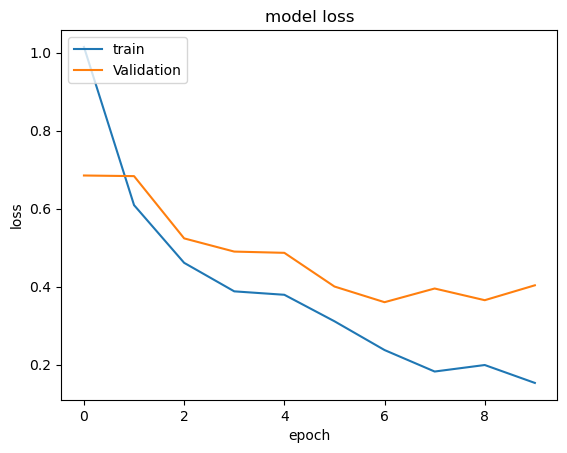

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [8]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the BiLSTM model:", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the BiLSTM model: 0.8703766465187073
93/93 [==============================] - 4s 40ms/step


In [9]:
predictions

array([[7.7459897e-04, 2.5523765e-04, 5.8730249e-05, 2.8201344e-03,
        9.9600631e-01, 8.4965577e-05],
       [6.7944516e-04, 2.5258597e-04, 5.1062249e-05, 2.4014059e-03,
        9.9653769e-01, 7.7849785e-05],
       [6.6431664e-04, 2.4461441e-04, 4.8460239e-05, 2.2481345e-03,
        9.9672168e-01, 7.2822055e-05],
       ...,
       [1.0984519e-03, 9.9807572e-01, 4.9300399e-04, 6.2369581e-05,
        1.9405487e-04, 7.6400414e-05],
       [2.3206105e-03, 9.9641883e-01, 7.0747867e-04, 1.3066288e-04,
        2.7575047e-04, 1.4666688e-04],
       [2.3669961e-03, 9.9624568e-01, 8.0197182e-04, 1.1534398e-04,
        2.7747086e-04, 1.9253913e-04]], dtype=float32)

In [10]:
# Confusion Matrix
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[408  22  64   0   2   0]
 [  0 422  49   0   0   0]
 [  3   7 410   0   0   0]
 [  0  10   0 382  99   0]
 [  2   6   0  91 433   0]
 [  0  27   0   0   0 510]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.99      0.82      0.90       496
           2       0.85      0.90      0.87       471
           3       0.78      0.98      0.87       420
           4       0.81      0.78      0.79       491
           5       0.81      0.81      0.81       532
           6       1.00      0.95      0.97       537

    accuracy                           0.87      2947
   macro avg       0.87      0.87      0.87      2947
weighted avg       0.88      0.87      0.87      2947



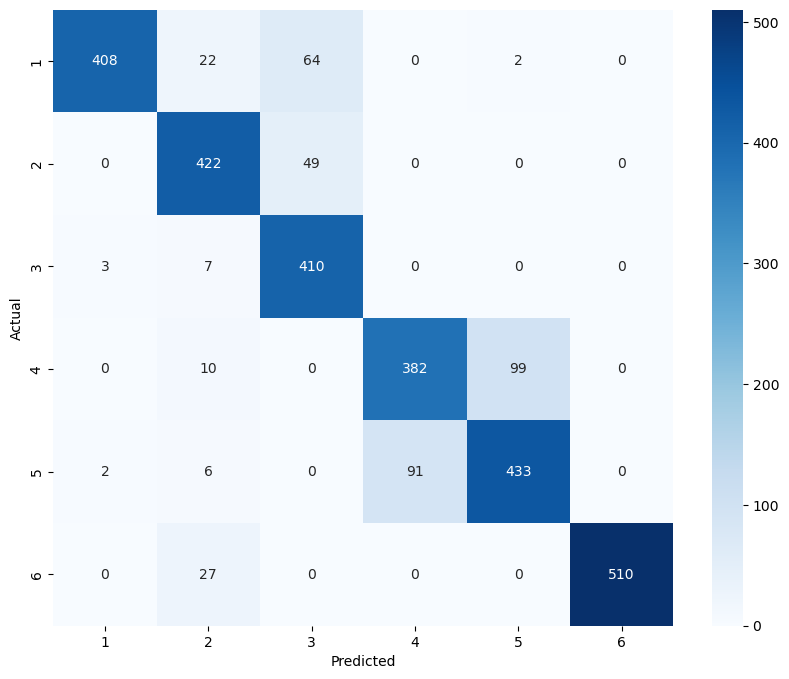

In [11]:
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)